In [1]:
import sys
sys.path.append('/kaggle/input/classes')

In [2]:
from JutePest import Preprocessor

preprocessor=Preprocessor(
    train_dir='/kaggle/input/jutepest/Jute_Pest_Dataset/train',
    test_dir='/kaggle/input/jutepest/Jute_Pest_Dataset/test',
    val_dir='/kaggle/input/jutepest/Jute_Pest_Dataset/val'
)

train_ds,test_ds,valid_ds,classes=preprocessor.get_datasets()
print(f'Train size: {len(train_ds)}, Test size: {len(test_ds)}, Val size: {len(valid_ds)}')

Train size: 6444, Test size: 379, Val size: 413


In [3]:
from JutePest import DataLoaderCreator

batch_size=32
dl_creator=DataLoaderCreator(train_ds,valid_ds,test_ds,batch_size)
train_dl,valid_dl,test_dl=dl_creator.get_dataloader()
print(f'Device being used: {dl_creator.device}')

Device being used: cuda


In [4]:
stats=preprocessor.stats
print(stats)

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


In [5]:
from JutePest import EDA

In [6]:
eda=EDA(classes,stats)

Label:  Beet Armyworm (0)


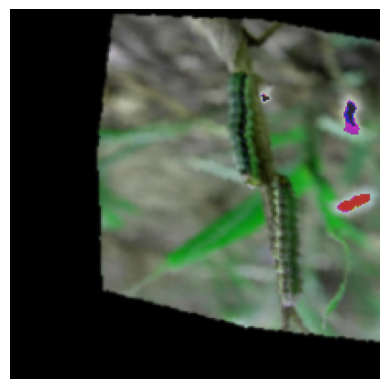

In [7]:
image,label=train_ds[10]
eda.show_image(image,label)

Label:  Field Cricket (3)


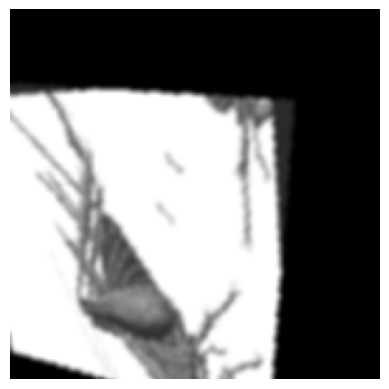

In [8]:
image,label=train_ds[1000]
eda.show_image(image,label)

Label:  Beet Armyworm (0)


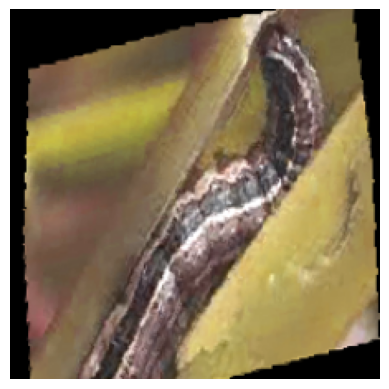

In [9]:
image,label=train_ds[100]
eda.show_image(image,label)

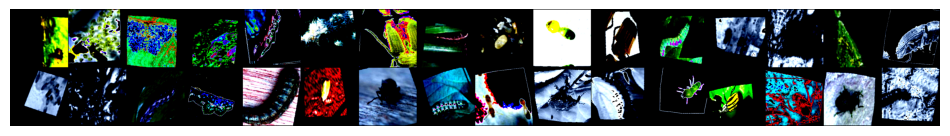

In [10]:
eda.show_batch(train_dl)

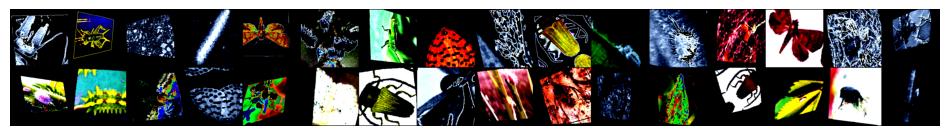

In [11]:
eda.show_batch(train_dl)

In [12]:
from JutePest import ImageClassificationModel

In [13]:
import torch.nn as nn
from torchvision import models

class Model(ImageClassificationModel):
    def __init__(self, out_size):
        super().__init__()

        self.efficientnet = models.efficientnet_b0(weights='DEFAULT')

        num_features = self.efficientnet.classifier[-1].in_features
        
        self.efficientnet.classifier[-1] = nn.Linear(num_features, out_size)

    def forward(self, x):
        x = self.efficientnet(x)
        return x

In [14]:
model=Model(out_size=len(classes))
model=model.to('cuda')

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 133MB/s] 


In [15]:
import torch.optim as optim

max_lr=0.001
weight_decay=1e-4
epochs=20

In [16]:
import time
start=time.time()

history=model.fit(epochs=epochs,max_lr=max_lr,train_loader=train_dl,val_loader=valid_dl,
                  weight_decay=weight_decay,grad_clip=0.1,
                 opt_func=optim.AdamW)

print(f'Training time: {(time.time()-start)/60} minutes')

Epoch [0], train_loss: 2.4590, train_acc: 0.2925, val_loss: 1.6161, val_acc: 0.5724
Epoch [1], train_loss: 0.9964, train_acc: 0.7247, val_loss: 0.4799, val_acc: 0.8634
Epoch [2], train_loss: 0.5245, train_acc: 0.8404, val_loss: 0.4508, val_acc: 0.8580
Epoch [3], train_loss: 0.4784, train_acc: 0.8510, val_loss: 0.4311, val_acc: 0.8929
Epoch [4], train_loss: 0.4900, train_acc: 0.8479, val_loss: 0.5424, val_acc: 0.8728
Epoch [5], train_loss: 0.4594, train_acc: 0.8574, val_loss: 0.7505, val_acc: 0.7902
Epoch [6], train_loss: 0.3538, train_acc: 0.8876, val_loss: 0.5843, val_acc: 0.8438
Epoch [7], train_loss: 0.2970, train_acc: 0.9078, val_loss: 0.3890, val_acc: 0.9018
Epoch [8], train_loss: 0.2541, train_acc: 0.9186, val_loss: 0.4487, val_acc: 0.8996
Epoch [9], train_loss: 0.2102, train_acc: 0.9323, val_loss: 0.4630, val_acc: 0.9107
Epoch [10], train_loss: 0.1774, train_acc: 0.9425, val_loss: 0.4887, val_acc: 0.8812
Epoch [11], train_loss: 0.1295, train_acc: 0.9579, val_loss: 0.4069, val_ac

In [17]:
from JutePest import Evaluation

In [18]:
eval=Evaluation(model,'cuda',stats)

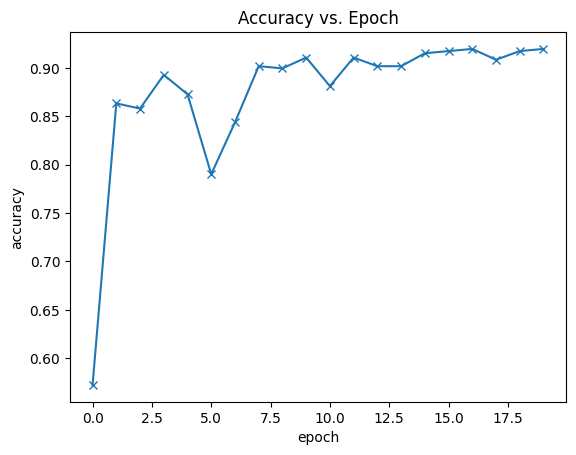

In [19]:
eval.plot_accuracies(history)

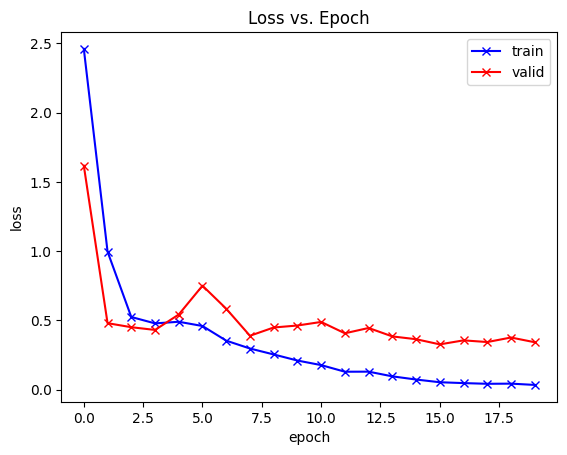

In [20]:
eval.plot_losses(history)

In [21]:
accuracy,f1,precision,recall=eval.evaluate(test_dl)
print(f'Test dataset metrics: ')
print(f'Accuracy: {accuracy*100}%')
print(f'F1 Score: {f1*100}%')
print(f'Precision Score: {precision*100}%')
print(f'Recall Score: {recall*100}%')

Test dataset metrics: 
Accuracy: 98.68073878627969%
F1 Score: 98.65884848106793%
Precision Score: 98.66946778711485%
Recall Score: 98.72549019607843%


In [22]:
import pandas as pd
import torch

In [23]:
import pandas as pd
import torch

def predict_images(model, test_loader, classes):
    model.eval()
    predictions = []
    actuals = []
    indices = []

    device = next(model.parameters()).device

    for idx, (img, label) in enumerate(test_loader):
        img = img.to(device)  

        with torch.no_grad():
            output = model(img)
            _, preds = torch.max(output, dim=1) 

        for i in range(preds.size(0)):
            predictions.append(classes[preds[i].item()])  
            actuals.append(classes[label[i].item()])  
            indices.append(idx * len(img) + i)  

    results_df = pd.DataFrame({
        'Index': indices,
        'Actual': actuals,
        'Predicted': predictions
    })

    return results_df

In [25]:
from sklearn.utils import shuffle
results_df=predict_images(model,test_dl,classes)
results_df=shuffle(results_df)

In [26]:
print(results_df.head(10))

     Index             Actual          Predicted
281    281          Pod Borer          Pod Borer
170    170  Jute Stem Girdler  Jute Stem Girdler
209    209   Jute Stem Weevil   Jute Stem Weevil
324    324            Termite            Termite
163    163    Jute Semilooper    Jute Semilooper
40      40            Cutworm            Cutworm
110    110         Jute Hairy         Jute Hairy
139    139      Jute Red Mite      Jute Red Mite
42      42            Cutworm            Cutworm
95      95         Jute Aphid         Jute Aphid


In [27]:
print(results_df.head(10))

     Index             Actual          Predicted
281    281          Pod Borer          Pod Borer
170    170  Jute Stem Girdler  Jute Stem Girdler
209    209   Jute Stem Weevil   Jute Stem Weevil
324    324            Termite            Termite
163    163    Jute Semilooper    Jute Semilooper
40      40            Cutworm            Cutworm
110    110         Jute Hairy         Jute Hairy
139    139      Jute Red Mite      Jute Red Mite
42      42            Cutworm            Cutworm
95      95         Jute Aphid         Jute Aphid
